In [1]:
#!pip install lifetimes

In [2]:
import datetime
import pandas as pd
import numpy as np
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from decimal import Decimal
import datetime as dt

df = pd.read_csv('P_TD_New_Elite_Data_Cohort_M3.csv')


In [3]:
# Generate summary data from transaction data
summary = summary_data_from_transaction_data(df, 'customer_id', 'order_date', 'CLV' )
summary = summary.reset_index()

In [4]:
# Fitting the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Visual representation of relationship between recency and frequency
#from lifetimes.plotting import plot_probability_alive_matrix
#fig = plt.figure(figsize=(12,8))
#plot_probability_alive_matrix(bgf)

<lifetimes.BetaGeoFitter: fitted with 1639 subjects, a: 0.00, alpha: 2268.20, b: 0.00, r: 21.75>

In [5]:
# Modeling the monetary value using Gamma-Gamma Model
ggf = GammaGammaFitter(penalizer_coef=1e-06)
return_customers_summary = summary[summary['frequency']>0]
ggf.fit(return_customers_summary['frequency'], return_customers_summary['monetary_value'])

# Calculating the conditional expected average profit for each customer per transaction
summary = summary[summary['monetary_value'] > 0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'], summary['monetary_value'])

# Checking the expected average value and the actual average value in the data to make sure the values are good
print("Expected Average Sales: {}".format(summary['exp_avg_sales'].mean()))
print("Actual Average Sales: {}".format(summary['monetary_value'].mean()))

Expected Average Sales: 127.25673806769807
Actual Average Sales: 122.80258201701096


In [6]:
# Initialize an empty dictionary to store results
results_dict = {'Discount Rate': [], 'Months': [], 'Total CLV': []}

# Iterate over different values for the prediction period in days, months, and discount rate
for t_days in range(30, 301, 30):  # Assuming you want to iterate from 1 to 30 days
    t_months = t_days // 30  # Equivalent number of months
    for discount_rate in [0.01, 0.25]:  # Add more values if needed
        # Predict future transactions for the specified period in days
        summary['pred_num_txn_days'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t_days, summary['frequency'], summary['recency'], summary['T']), 2)

        # Predicting Customer Lifetime Value for the specified period in months
        summary['predicted_clv_months'] = ggf.customer_lifetime_value(bgf,
                                                                           summary['frequency'],
                                                                           summary['recency'],
                                                                           summary['T'],
                                                                           summary['monetary_value'],
                                                                           time=t_months,
                                                                           freq='D',
                                                                           discount_rate=discount_rate)

        summary['manual_predicted_clv_days'] = summary['pred_num_txn_days'] * summary['exp_avg_sales']
        # Store results in the dictionary
        results_dict['Discount Rate'].append(discount_rate)
        results_dict['Months'].append(t_months)
        results_dict['Total CLV'].append(summary['predicted_clv_months'].sum())

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results_dict)

# Reshape the DataFrame for better visualization
pivot_df = results_df.pivot(index='Discount Rate', columns='Months', values='Total CLV')
pivot_df.loc['Average'] = pivot_df.mean()

# Calculate the difference from the previous month, including the difference from Month 0 to Month 1
pivot_df_diff = pivot_df.diff(axis=1)
pivot_df_diff.insert(0, 0, pivot_df[1]) # Insert the Month 1 values as the difference from Month 0
pivot_df_diff = pivot_df_diff.drop(columns=[1]) # Drop the original Month 1 difference column

# Display the DataFrame
print(pivot_df)
print(pivot_df_diff)

Months                   1             2             3              4   \
Discount Rate                                                            
0.01           30800.546171  61296.136438  91489.790169  121384.496833   
0.25           24886.841306  44796.314351  60723.892786   73465.955535   
Average        27843.693738  53046.225395  76106.841478   97425.226184   

Months                    5              6              7              8   \
Discount Rate                                                               
0.01           150983.216302  180288.879143  209304.386906  238032.612415   
0.25            83659.605734   91814.525893   98338.462020  103557.610922   
Average        117321.411018  136051.702518  153821.424463  170795.111668   

Months                    9              10  
Discount Rate                                
0.01           266476.400046  294638.566019  
0.25           107732.930043  111073.185341  
Average        187104.665045  202855.875680  
Months       

In [7]:
pivot_df_diff = pd.DataFrame(pivot_df_diff)
pivot_df_diff = pivot_df_diff.rename(columns={0: 1})
pivot_df_diff

Months,1,2,3,4,5,6,7,8,9,10
Discount Rate,,,,,,,,,,
0.01,30800.546171,30495.590268,30193.653731,29894.706664,29598.719469,29305.662841,29015.507763,28728.225508,28443.787632,28162.165972
0.25,24886.841306,19909.473045,15927.578436,12742.062749,10193.650199,8154.920159,6523.936127,5219.148902,4175.319121,3340.255297
Average,27843.693738,25202.531656,23060.616083,21318.384706,19896.184834,18730.291500,17769.721945,16973.687205,16309.553377,15751.210635


# Task
Modify the code in the selected cell to calculate the average CLV per customer over time. First, sum the CLV by `order_month` from the `df` DataFrame and assign month numbers starting from 0. Then, sum the CLV by month from the `pivot_df` DataFrame and append it, ensuring the month numbers continue sequentially from the previous step. Finally, divide the total CLV for each month by the total number of unique customers (`df['customer_id'].nunique()`) and create a chart to visualize the average CLV over these combined months.

## Prepare initial clv data

### Subtask:
Calculate the sum of CLV by the order month from the `df` DataFrame and assign month numbers starting from 0 for the oldest month.


**Reasoning**:
Convert 'order_date' to datetime, extract month and year, calculate month numbers based on the earliest month, group by month number, sum CLV, and rename the CLV column.



In [8]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_month'] = df['order_date'].dt.to_period('M')

earliest_month = df['order_month'].min()
df['month_number'] = (df['order_month'] - earliest_month).apply(lambda x: x.n)

df_clv_by_month = df.groupby('month_number')['CLV'].sum().reset_index()
df_clv_by_month = df_clv_by_month.rename(columns={'CLV': 'Total CLV'})

display(df_clv_by_month)

,month_number,Total CLV
0,0,159351.71
1,1,85479.01
2,2,65829.95


## Prepare predicted clv data

### Subtask:
Extract the total CLV by month from the `pivot_df` DataFrame and adjust the month numbers to follow sequentially after the initial months from step 1.


**Reasoning**:
Extract the average total CLV from the pivot_df and create a new dataframe with sequential month numbers starting after the last month in df_clv_by_month.



In [9]:
pivot_df_avg = pivot_df_diff.loc['Average'].reset_index()
last_month_df = df_clv_by_month['month_number'].max()
pivot_df_avg['Months'] = pivot_df_avg['Months'] + last_month_df
pivot_df_avg = pivot_df_avg.rename(columns={'Months': 'month_number', 'Average': 'Total CLV'})
display(pivot_df_avg)

,month_number,Total CLV
0,3,27843.693738
1,4,25202.531656
2,5,23060.616083
3,6,21318.384706
4,7,19896.184834
5,8,18730.291500
6,9,17769.721945
7,10,16973.687205
8,11,16309.553377
9,12,15751.210635


## Combine clv data

### Subtask:
Concatenate the initial CLV data and the predicted CLV data into a single DataFrame.


**Reasoning**:
Concatenate the historical and predicted CLV dataframes and sort by month number.



In [10]:
combined_clv_data = pd.concat([df_clv_by_month, pivot_df_avg], ignore_index=True)
combined_clv_data = combined_clv_data.sort_values(by='month_number')
display(combined_clv_data)

,month_number,Total CLV
0,0,159351.710000
1,1,85479.010000
2,2,65829.950000
3,3,27843.693738
4,4,25202.531656
5,5,23060.616083
6,6,21318.384706
7,7,19896.184834
8,8,18730.291500
9,9,17769.721945


## Calculate average clv

### Subtask:
Divide the total CLV for each month by the total number of unique customers (`df['customer_id'].nunique()`).


**Reasoning**:
Divide the total CLV for each month by the total number of unique customers and store the result in a new column.



In [12]:
num_customers= df['customer_id'].nunique()
combined_clv_data['Average CLV'] = combined_clv_data['Total CLV'] / num_customers
display(combined_clv_data)

,month_number,Total CLV,Average CLV
0,0,159351.710000,97.224960
1,1,85479.010000,52.153148
2,2,65829.950000,40.164704
3,3,27843.693738,16.988221
4,4,25202.531656,15.376773
5,5,23060.616083,14.069930
6,6,21318.384706,13.006946
7,7,19896.184834,12.139222
8,8,18730.291500,11.427878
9,9,17769.721945,10.841807


## Visualize average clv

### Subtask:
Plot the calculated average CLV per customer over the combined months.


**Reasoning**:
Plot the calculated average CLV per customer over the combined months using a line plot, as requested in the instructions.



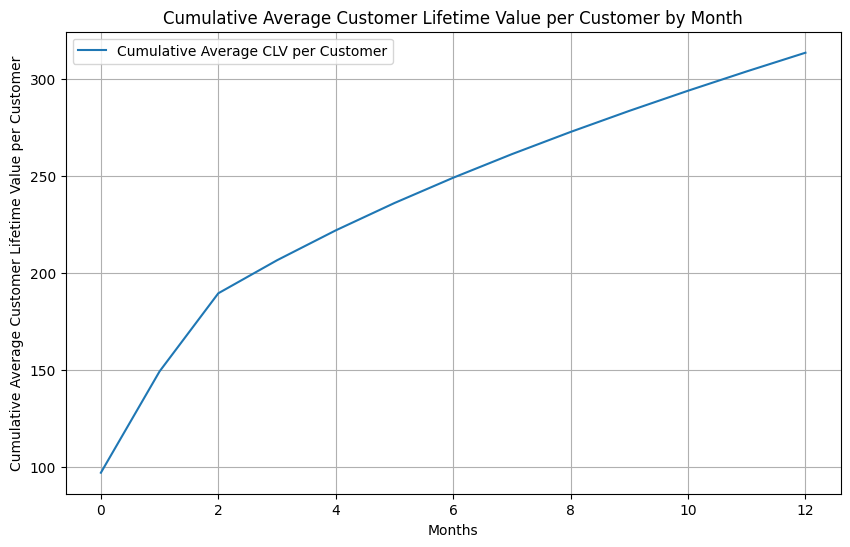

In [13]:
import matplotlib.pyplot as plt

# Calculate the cumulative average CLV
combined_clv_data['Cumulative Average CLV'] = combined_clv_data['Average CLV'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(combined_clv_data['month_number'], combined_clv_data['Cumulative Average CLV'], label='Cumulative Average CLV per Customer')
plt.xlabel('Months')
plt.ylabel('Cumulative Average Customer Lifetime Value per Customer')
plt.title('Cumulative Average Customer Lifetime Value per Customer by Month')
plt.legend()
plt.grid(True)
plt.show()

## Summary:

### Data Analysis Key Findings

*   The historical CLV data was aggregated by month, with months numbered sequentially starting from 0.
*   Predicted average CLV data from the `pivot_df` was extracted and its month numbers were adjusted to continue sequentially from the last historical month.
*   The historical and predicted CLV data were successfully combined into a single DataFrame.
*   Average CLV per customer for each month was calculated by dividing the total monthly CLV by the total number of unique customers.
*   A line plot was generated to visualize the trend of average CLV per customer over the combined historical and predicted months.

### Insights or Next Steps

*   Analyze the trend in the average CLV over the combined months to understand the projected customer value growth or decline.
*   Consider segmenting customers and calculating the average CLV for each segment to identify high-value groups.
